In [2]:
import os
import numpy as np
import torch
import json

In [52]:
# initialise arguments
concept = 'gender'
tests = ['t_test', 'wanda']
test_name = f'skilled_neuron_%s'
ratio = ['0.3/dof_19_conf_0.1', 0.01]
extensions = ['json', 'pt']
seed = 0
root = f'../results/results_seed_{seed}/stable-diffusion/baseline/runwayml/stable-diffusion-v1-5/modularity/{concept}/%s/%s/'
timesteps = 51
n_layers = 16

In [53]:
# read data for all concepts
all_concept_data = {}
print("Reading all the data")
# read data
for iter, test in enumerate(tests):
    test_folder = test_name % test
    all_concept_data[test_folder] = {}
    for t in range(timesteps):
        all_concept_data[test_folder][t] = {}
        for l in range(n_layers):
            # read data
            path = os.path.join(root % (test_folder, ratio[iter]), f'timestep_{t}_layer_{l}.{extensions[iter]}')
            if test == 't_test':
                with open(path, 'r') as f:
                    data = json.load(f)
                    all_concept_data[test_folder][t][l] = np.array(data)
                    print(f"Read data for {test_folder} timestep {t} layer {l}", all_concept_data[test_folder][t][l].shape)
            elif test == 'wanda':
                all_concept_data[test_folder][t][l] = torch.load(path).cpu().numpy()
                # with open(path, 'r') as f:
                #     data = json.load(f)
                # all_concept_data[test_folder][t][l] = np.array(data)
                print(f"Read data for {test_folder} timestep {t} layer {l}", all_concept_data[test_folder][t][l].shape)

Reading all the data
Read data for skilled_neuron_t_test timestep 0 layer 0 (1280,)
Read data for skilled_neuron_t_test timestep 0 layer 1 (1280,)
Read data for skilled_neuron_t_test timestep 0 layer 2 (2560,)
Read data for skilled_neuron_t_test timestep 0 layer 3 (2560,)
Read data for skilled_neuron_t_test timestep 0 layer 4 (5120,)
Read data for skilled_neuron_t_test timestep 0 layer 5 (5120,)
Read data for skilled_neuron_t_test timestep 0 layer 6 (5120,)
Read data for skilled_neuron_t_test timestep 0 layer 7 (5120,)
Read data for skilled_neuron_t_test timestep 0 layer 8 (5120,)
Read data for skilled_neuron_t_test timestep 0 layer 9 (5120,)
Read data for skilled_neuron_t_test timestep 0 layer 10 (2560,)
Read data for skilled_neuron_t_test timestep 0 layer 11 (2560,)
Read data for skilled_neuron_t_test timestep 0 layer 12 (2560,)
Read data for skilled_neuron_t_test timestep 0 layer 13 (1280,)
Read data for skilled_neuron_t_test timestep 0 layer 14 (1280,)
Read data for skilled_neuron_

In [49]:
# get shapes of the weights
shapes = {}
# initialise SD model pretrained
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from diffusers.models.activations import LoRACompatibleLinear

# get the model
model = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5', torch_dtype=torch.float16)

# get the shapes of the weights
for name, module in model.unet.named_modules():
   if isinstance(module, LoRACompatibleLinear) and 'ff.net' in name and not 'proj' in name:
         shapes[name] = module.weight.shape

# sort shapes by key values
shapes = dict(sorted(shapes.items()))
shapes = dict(sorted(shapes.items()))
shapes = [shapes[key] for key in shapes.keys()]

# convert wanda data to binary masks

for t in range(timesteps):
    for l in range(n_layers):
      binary_mask = torch.zeros(shapes[l], dtype=torch.float16)
      indices = all_concept_data['skilled_neuron_wanda'][t][l]
      indices = torch.tensor(indices, dtype=torch.int64)
      binary_mask[indices[:, 0], indices[:, 1]] = 1
      # save the data
      all_concept_data['skilled_neuron_wanda'][t][l] = binary_mask.cpu().numpy()
      print(f"Converted data for timestep {t} layer {l}", all_concept_data['skilled_neuron_wanda'][t][l].mean())
        
                 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyError: 0

In [35]:
all_concept_data['skilled_neuron_wanda'][1][0].mean()

0.004322

Plotting sparsity for t_test
Plotting sparsity for wanda


TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


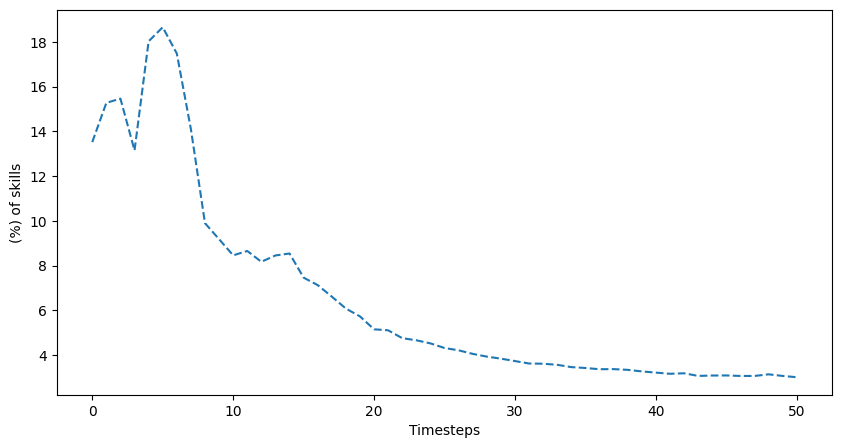

In [54]:
# Plot sparsity of the data for each test

import matplotlib.pyplot as plt

fig =  plt.figure(figsize=(10, 5))

for iter, test in enumerate(tests):
    print(f"Plotting sparsity for {test}")
    test_folder = test_name % test
    sparsity_all_timesteps = []
    for t in range(timesteps):
        sparsity = []
        for l in range(n_layers):
            sparsity.append(np.mean(all_concept_data[test_folder][t][l]))
        mean_sparsity = np.mean(sparsity)
        sparsity_all_timesteps.append(mean_sparsity)
        # print(f"Mean sparsity for {test_folder} timestep {t}", mean_sparsity)

    sparsity_all_timesteps = np.array(sparsity_all_timesteps)
    plt.plot(sparsity_all_timesteps * 100.0, label=f"{test}", linestyle='--')
    plt.xlabel('Timesteps')
    plt.ylabel('(%) of skills')
    # fig.plot(sparsity_all_timesteps, label=f"{test}", linestyle='--'

plt.title(f"Sparsity of the skills for concept - {concept}")
plt.legend()
plt.xticks(np.arange(0, timesteps, 5))
plt.tight_layout()
plt.show()


Mean sparsity for skilled_neuron_t_test timestep 0 0.29437255859375
Mean sparsity for skilled_neuron_t_test timestep 1 0.254541015625
Mean sparsity for skilled_neuron_t_test timestep 2 0.24385986328125
Mean sparsity for skilled_neuron_t_test timestep 3 0.2184814453125
Mean sparsity for skilled_neuron_t_test timestep 4 0.205517578125
Mean sparsity for skilled_neuron_t_test timestep 5 0.16549072265625
Mean sparsity for skilled_neuron_t_test timestep 6 0.16397705078125
Mean sparsity for skilled_neuron_t_test timestep 7 0.14738769531249998
Mean sparsity for skilled_neuron_t_test timestep 8 0.14078369140625
Mean sparsity for skilled_neuron_t_test timestep 9 0.13753662109374998
Mean sparsity for skilled_neuron_t_test timestep 10 0.13328857421875
Mean sparsity for skilled_neuron_t_test timestep 11 0.1273681640625
Mean sparsity for skilled_neuron_t_test timestep 12 0.12608642578125
Mean sparsity for skilled_neuron_t_test timestep 13 0.12509765625
Mean sparsity for skilled_neuron_t_test timeste

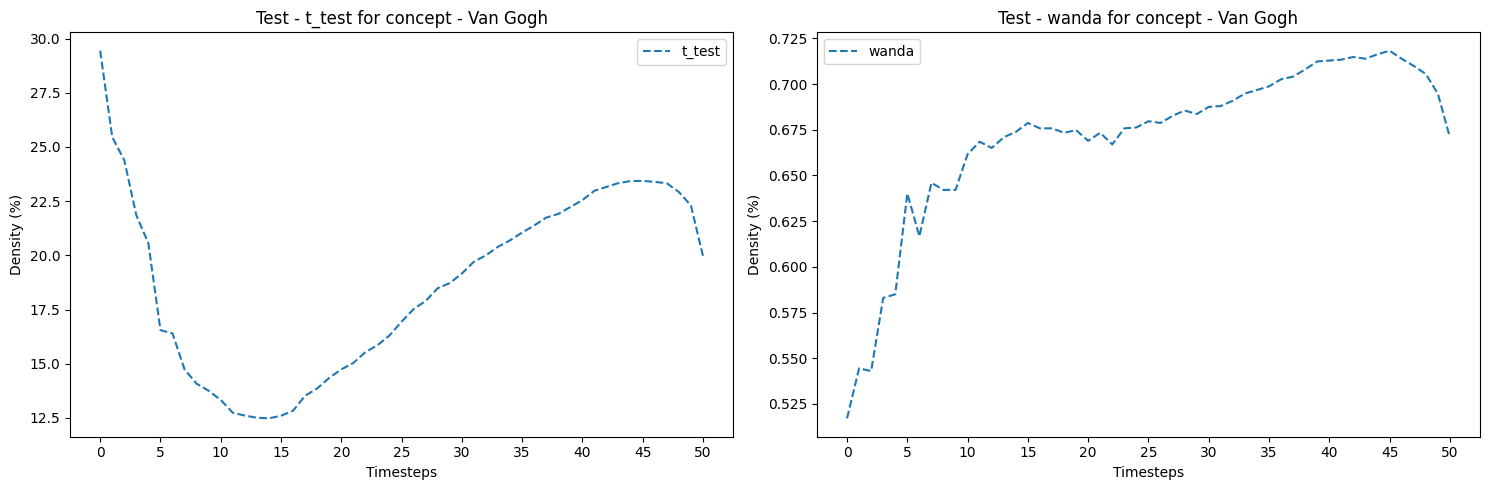

In [40]:
# Draw two different plots for the two tests

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for iter, test in enumerate(tests):
    test_folder = test_name % test
    sparsity_all_timesteps = []
    for t in range(timesteps):
        sparsity = []
        for l in range(n_layers):
            sparsity.append(np.mean(all_concept_data[test_folder][t][l]))
        mean_sparsity = np.mean(sparsity)
        sparsity_all_timesteps.append(mean_sparsity)
        print(f"Mean sparsity for {test_folder} timestep {t}", mean_sparsity)

    sparsity_all_timesteps = np.array(sparsity_all_timesteps)
    axs[iter].plot(sparsity_all_timesteps * 100.0, label=f"{test}", linestyle='--')
    axs[iter].set_xlabel('Timesteps')
    axs[iter].set_ylabel('Density (%)')
    axs[iter].set_title(f"Test - {test} for concept - {concept}")
    axs[iter].legend()
    axs[iter].set_xticks(np.arange(0, timesteps, 5))

plt.tight_layout()
plt.show()